# Applied Linear Algebra - Lab 4
Ferdowsi University of Mashhad - Computer Engineering Department

Winter 2023

### Table of Contents
* [Encoding Data as a Matrix](#Encoding-Data-as-a-Matrix)
    * [mnist-explain](#mnist-explain)
    * [Exercise 1](#ex1)
* [SVD](#svd)
    * [Exercise 2](#ex2)
* [PCA](#pca)
    * [PCA via SVD steps](#pca-via-svd)
    * [Exercise 3](#ex3)
    * [Exercise 4](#ex4)
    * [Dimension reduction on MNIST](#dimension-reduction-on-mnist)
        * [Exercise 5](#ex5)
        * [Exercise 6](#ex6)

#### Helper functions:
You don't have to change implementation of the following functions, but you will use them:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

class multi_var():
    def __init__(self, mean_lists, cov_mats, size, np_random_seed=None):
        """
        Args:
            list of mean_list for each class id (sequence):       desired mean of data along each axis
            list of cov_mat for each class id (2d squared seq):   covariance matrix 
            size:                                      size of each class
        """

        self.mean_lists = mean_lists
        self.cov_mats = cov_mats
        self.size = size
        self.num_classes = len(mean_lists)
        self.dim = len(mean_lists[0])
        assert len(mean_lists) == len(cov_mats), 'len(mean_lists) != len(cov_mats)'
        self.data_matrix = None

        if np_random_seed != None:
            np.random.seed(np_random_seed)

        for c in range(self.num_classes):
            if not is_pos_def(np.array(self.cov_mats[c])):
                print('covariance matrix not positive definite!')
                exit()
            curr_class_labels = (np.ones((self.size)) * c).astype(int)
            curr_class_data_mat = np.vstack((np.random.multivariate_normal(self.mean_lists[c], self.cov_mats[c],
                                                                           self.size).T, curr_class_labels)).T
            if c == 0:
                self.data_matrix = curr_class_data_mat
            else:
                self.data_matrix = np.vstack((self.data_matrix, curr_class_data_mat))

    def get_data(self):
      return unison_shuffled_copies(self.data_matrix[:, 0:self.dim], self.data_matrix[:, -1])

def scatter_2d(X, y='def'):
    if y=='def': y = np.zeros(X.shape[0])
    if X.shape[1] == 2:
        plt.clf()
        
        plt.scatter(x = X[:, 0], y = X[:, 1], c = y)
        plt.axis('equal')
        plt.show()
    else:
        plt.clf()
        plt.scatter(X[:, 0], y, c = y)
        plt.show()

# Encoding Data as a Matrix <a class="anchor" id="Encoding-Data-as-a-Matrix"></a>

Before we discuss main topics of this homework, it will be useful to standardize the way in which data is encoded in matrix form. Since PCA and SVD are linear techniques, this will allow us to manipulate the data using linear transformations more easily (Linear transformation was discussed in first project of this semester). It’s simplest to start with an example, so suppose that you are given the width $w$ , height $h$ , and length $l$ measurements of $n = 1000$ rectangular boxes. We can encode the measurements of box $i$ as a $( w i , h i , l i )$ tuple called a sample. Each sample is a vector in $d = 3$ dimensions, since there are 3 numbers describing it. Because vectors are typically written horizontally, we transpose the vectors to write them vertically:

$$
x_i = \begin{pmatrix}
w_i \\
h_i \\
l_i
\end{pmatrix}
, \;\;
{x_i}^T = \begin{pmatrix}
w_i & h_i & l_i
\end{pmatrix}
$$

To pack the data into a single object we simply stack the samples as rows of a data matrix,

$$
X = \begin{pmatrix}
w_1 & h_1 & l_1\\
w_2 & h_2 & l_2\\
... & ... & ... \\
w_{1000} & h_{1000} & l_{1000}
\end{pmatrix}
$$

The rows of this matrix correspond to a single sample, i.e., all the measurements of a particular sample.
In the general case, we are working with a $d$-dimensional dataset comprised of $n$ samples. Instead of using letters like $h$ , $w$ , and $l$ to denote the different coordinates, we simply enumerate the entries of each data-vector so that $
{x_i}^T = \begin{pmatrix}
x_{i1} & ... & x_{id}
\end{pmatrix}
$


Let's look at an example of encoding Data as a matrix:

### MNIST Dataset: <a class="anchor" id="mnist-explain"></a>

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.

The MNIST database contains 60,000 training images and 10,000 testing images. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. (often times we scale pixel values down to \[0, 1\] range)

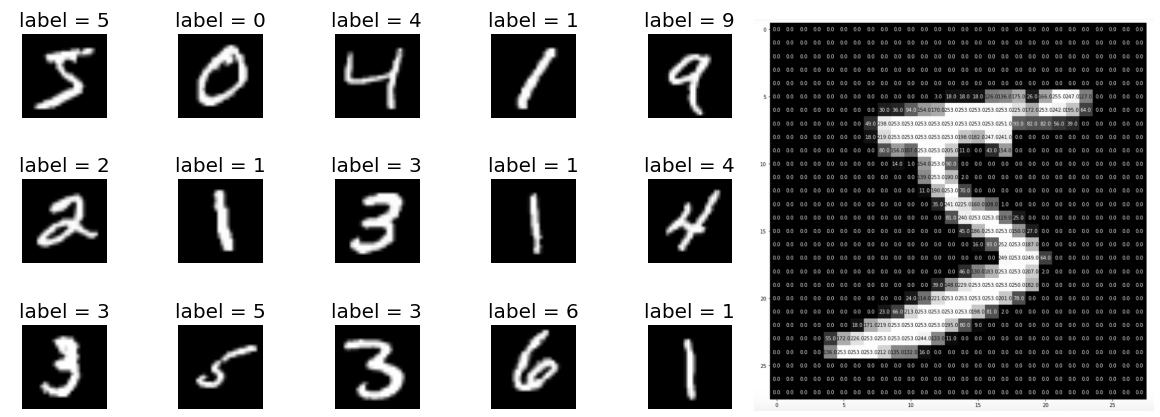

Each image is a sample, since each image has 28*28 pixels and each pixel is a feature, we are working with a 784-dimensional dataset. for simplicity we only take the first 1000 of images, so we have 1000 samples.



In [2]:
def get_mnist_data(n = 1000):
    '''
    returns first `n` number of samples on MNIST dataset
    X --> (n, 28, 28)
    y --> (n, )
    '''
    with open('./data.pickle', 'rb') as handle:
        X = pickle.load(handle)
        
    with open('./targets.pickle', 'rb') as handle:
        y = pickle.load(handle)
        
    return X[0:n], y[0:n]

## Exercise 1: <a class="anchor" id="ex1"></a>
**Question1**: using the `get_mnist_data()` function, get the first 1000 of images:

In [3]:
n_samples = 1000 # SOL 

mnist_x, mnist_y = get_mnist_data(1000)
mnist_x.shape

(1000, 28, 28)

$x_i$ is the i-th image (sample) and is a 28*28 array, we want to represent each sample as a row vector:
$$
{x_i} = \begin{pmatrix}
\text{pixel value}_{1} & \text{pixel value}_{2} & ... \text{pixel value}_{784}
\end{pmatrix}
$$

**Question2**: complete the function `get_flatten_mnist_data` which returns `n_sample` reshaped samples such that the $X$ is a (`n_sample`, 784) matrix:



In [4]:
def get_flatten_mnist(n_sample):
    X, y = get_mnist_data(n_sample)
    # reshape all images into a column vector (784, ):
    X_reshaped = np.reshape(X, (X.shape[0], 28*28)) # SOL 
    return X_reshaped, y

In [5]:
Xx, yy = get_flatten_mnist(1000)
Xx.shape

(1000, 784)

now we are representing our dataset like this:
$$
X_{1000 \times 784} = 
\begin{pmatrix}
{\text{image1}}_{\text{pixel 1}} & {\text{image1}}_{\text{pixel 2}} & ... & {\text{image1}}_{\text{pixel 784}} \\
{\text{image2}}_{\text{pixel 1}} & {\text{image2}}_{\text{pixel 2}} & ... & {\text{image2}}_{\text{pixel 784}} \\
... & ... & ... & ... \\
{\text{image1000}}_{\text{pixel 1}} & {\text{image1000}}_{\text{pixel 2}} & ... & {\text{image1000}}_{\text{pixel 784}} 
\end{pmatrix}
$$

# SVD <a class="anchor" id="svd"></a>
The Singular Value Decomposition (SVD) separates any matrix into simple pieces. it provides a numerically stable matrix decomposition that can be used for
a variety of purposes and is guaranteed to exist

In many domains, complex systems will generate data that is naturally arranged in
large matrices, or more generally in arrays. For example, a time-series of data from an
experiment or a simulation may be arranged in a matrix with each column containing all of
the measurements at a given time. 

The pixel values in a grayscale image may be stored in a matrix,
or these images may be reshaped into large row vectors in a matrix to represent the
frames of a movie. Remarkably, the data generated by these systems are typically low rank,
meaning that there are a few dominant patterns that explain the high-dimensional data. The
SVD is a numerically robust and efficient method of extracting these patterns from data.

Generally, we are interested in analyzing a large data set $X_{n \times d}$:

$$
X = \begin{bmatrix}
\text{---} & x_1 & \text{---} \\
\text{---} & x_2 & \text{---} \\
. & . & . \\
\text{---} & x_n & \text{---} \\
\end{bmatrix}
$$

The rows $x_i \in C_d$ may be measurements from simulations or experiments. For example, columns may represent images that have been reshaped into row vectors with as
many elements as pixels in the image.

The SVD is a unique matrix decomposition that exists for every matrix
 $X_{n \times d}$:
 
$$
\bf X = \bf U \times \Sigma \times \bf V^\intercal
$$

where $ \bf U_{n \times n}$ is a matrix containing unit eigenvectors of $X X^\intercal$ and $\bf V_{d \times d}$ is containing unit eigenvectors of $X^\intercal X$.

$ \bf \Sigma$ is a diagonal matrix containing square roots of the equal eigenvalues of $ X X^\intercal$ and $X^\intercal X$ (Singular Values $\sigma$.)

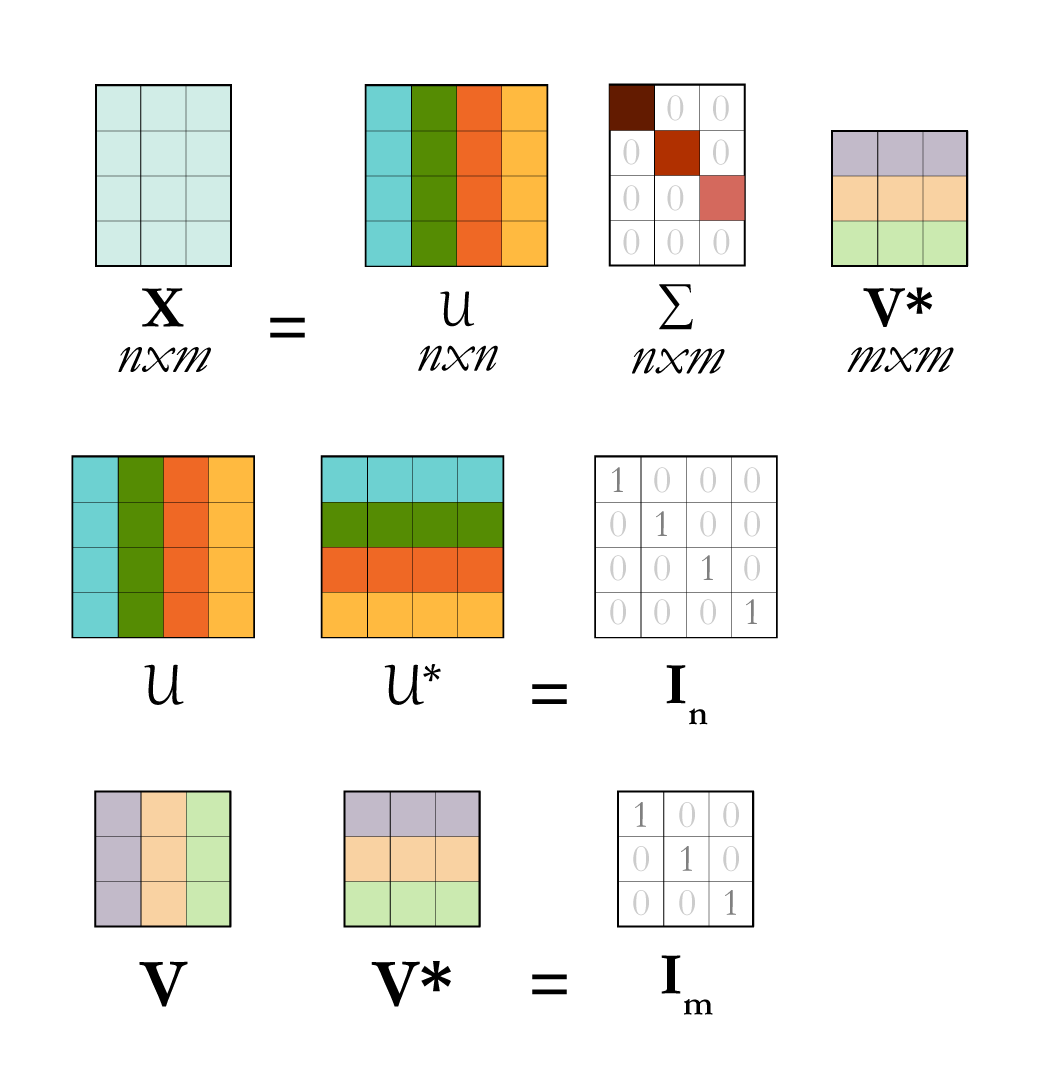

## Exercise 2 <a class="anchor" id="ex2"></a>
**Question1:** Define function `svd` which takes matrix $ \bf X_{n \times d}$ and applies SVD decomposition then returns $ \bf U_{n \times n} , \bf \Sigma_{n \times d},  \bf V^\intercal_{d \times d} $

We've seen steps of SVD decomposition in Chapter 7 of the course. (https://www.youtube.com/watch?v=dynj8r5loog&loop=0)

In [4]:
from numpy.linalg import eig
from numpy import argsort
from numpy import diag

def svd(X):
    # compute X.T * X
    xtx = X.T @ X # SOLUTION
    
    # calculate eigenvalues and eigenvectors of XTX
    # use linalg.eig() function, it returns eigenvalues and normalized (unit length) eigenvectors,
    # such that the i-th column
    # is the eigenvector corresponding to the i-th eigenvalue
    eig_vals, V = eig(xtx) # SOLUTION
    # singular values of X are the square root of the non-negative eigenvalues of XtX or XXt
    singular_vals = np.sqrt(eig_vals) # SOLUTION
    
    # sort both sigular values and matrix V in descending order so that the higher values are placed before the lower ones.
    # use np.argsort(), it returns the indices that would sort an array
    sort_indices = argsort(singular_vals) # SOLUTION
    sort_indices = sort_indices[::-1] #descending
    singular_vals = singular_vals[sort_indices] # SOLUTION
    V = V[:, sort_indices] # SOLUTION
    
    # U is matrix of eigenvectors of XXT
    # calculate U using X, V and singular_vals
    U = X @ V / singular_vals # SOLUION
    
    # sigma matrix is a diagonal matirx with singular values of X in its diagonal
    # singluar_vals is an array of singular values of X
    sigma = diag(singular_vals) # SOLUTION

    return U.real, sigma.real, V.T.real

In [5]:
xx = np.random.random((5, 5))
print(xx)
ux, sx, vx = svd(xx)

[[0.42507554 0.0208288  0.70552648 0.09824724 0.97383525]
 [0.99105368 0.18716138 0.95088299 0.01593065 0.91522457]
 [0.06669057 0.39348317 0.6859946  0.02684843 0.65640134]
 [0.67966198 0.33625497 0.55709245 0.7158583  0.60001298]
 [0.73721021 0.44122241 0.58642018 0.94403049 0.28114325]]


if `svd()` implementation is correct, matrix `xx` must be equal to $U \times S \times V$

In [6]:
print('Original matrix: \n', xx)
print('U S V: \n', ux @ sx @ vx)

Original matrix: 
 [[0.66431028 0.22751243 0.31951269 0.35525959 0.96773814]
 [0.09237205 0.57719709 0.94831798 0.70674524 0.23332079]
 [0.7793034  0.49834349 0.36670203 0.29812045 0.43329241]
 [0.89770955 0.39727245 0.97384226 0.71168529 0.72987547]
 [0.56945955 0.00686783 0.52545631 0.82783542 0.58843046]]
U S V: 
 [[0.66431028 0.22751243 0.31951269 0.35525959 0.96773814]
 [0.09237205 0.57719709 0.94831798 0.70674524 0.23332079]
 [0.7793034  0.49834349 0.36670203 0.29812045 0.43329241]
 [0.89770955 0.39727245 0.97384226 0.71168529 0.72987547]
 [0.56945955 0.00686783 0.52545631 0.82783542 0.58843046]]


# PCA <a class="anchor" id="pca"></a>
In this section, we first explain why we need a dimension reduction tool like PCA, then explain what is PCA and then steps of PCA.

### Dimension Reduction:

The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms. The main goal of a PCA analysis is to identify patterns in data; PCA aims to detect the correlation between variables. If a strong correlation between variables exists, the attempt to reduce the dimensionality only makes sense.

### What is PCA:
In a nutshell, this is what PCA is all about: Finding the directions of maximum variance in high-dimensional data and project it onto a smaller dimensional subspace while retaining most of the information.
Principal components analysis (PCA) is one of the central uses of the SVD, providing a coordinate system to represent high-dimensional correlated data. The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Often, the desired goal is to reduce the dimensions of a $d$-dimensional dataset by projecting it onto a $(k)$-dimensional subspace (where $k \leq d$) in order to increase the computational efficiency while retaining most of the information. An important question is “what is the size of $k$ that represents the data ‘well’?”

Later, we will compute eigenvectors (the principal components) of a dataset and collect them in a projection matrix. Each of those eigenvectors is associated with an eigenvalue which can be interpreted as the “length” or “magnitude” of the corresponding eigenvector. If some eigenvalues have a significantly larger magnitude than others, then the reduction of the dataset via PCA onto a smaller dimensional subspace by dropping the “less informative” eigenpairs is reasonable.

(make sure to understand the idea of PCA explained in the last paragraph)
## Summary of PCA via SVD (reduction to k-dimensional subspace): <a class="anchor" id="pca-via-svd"></a>
1. Subtract mean of data from dataset. 
$$
\bar{X} = X - \mu
$$
2. Perform SVD on the the mean-subtracted dataset. 
    **Important**: $V^T$ is the matrix of principal components
$$
U, S, V = svd(\bar{X}) 
$$
$$
V^T = \begin{pmatrix}
PC_1 & PC_2 & ... & PC_d
\end{pmatrix}
$$
3. Choose the $k$ PCs(principal components) that correspond to the $k$ largest eigenvalues where $k$ is the number of dimensions of the new feature subspace ($k \leq d$).
4. Construct the projection matrix $W$ from the selected $k$ PCs.
5. Transform the original dataset $X$ via $W$ to obtain a $k$-dimensional feature subspace $Y$. 

The Eigenvectors in the matrix $V^T$ in step 2 (remember from svd that $V$ is the eigenvectors of $X^TX$), are called principal components and they represent dominant pattern in our data. in step 3 and 4 we use Eigenvectors (Principal Components) with high Eigenvaluse to create a projection matrix, we drop the Eigenvectors (Principal Components) with low eigenvalues, since they represent weak patterns and they are not good to describe the data (remember we want to reduce dimension while preserving maximum information about data). in step 5, using the projection matrix in step 4, we will project original mean-subtracted Dataset to the lower dimensional subspace (This projection is a Linear transformation, Linear Transformations were discussed in the First Project of this semester).

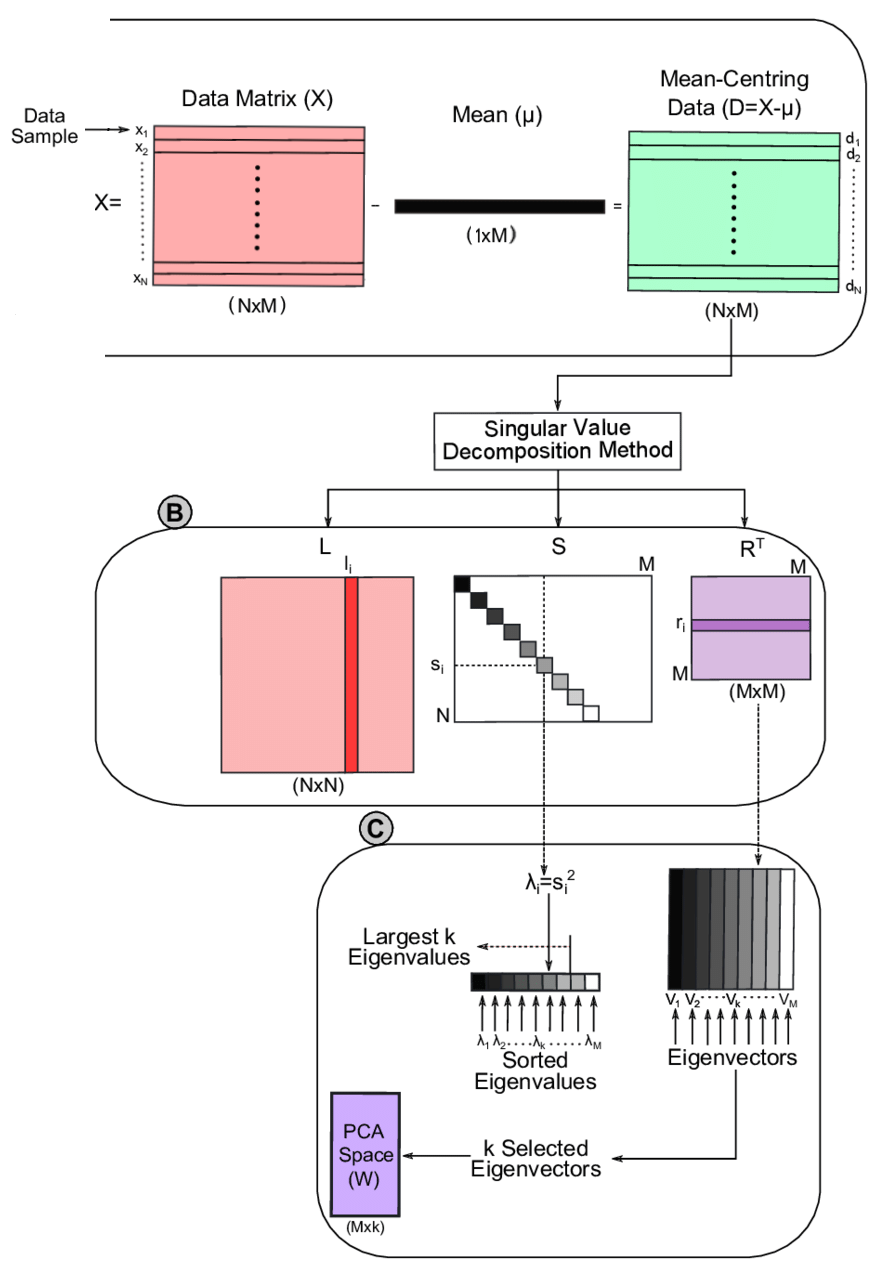


## More about PCA (Optional Reading): 

From the view of statistics, PCA invloves eigendocmposition of Covariance matrix of the dataset (this is the reason that we subtract the mean from dataset). In this homework we want to use SVD to do PCA and our goal is not to look into the statistics of PCA (You can read http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_PCA09.pdf for more info)

We talked about reducing dimension, let's answer some questions:

#### which features can we ignore to reduce dimension?
- Constant parameters
- Constant parameter with some noise
- Parameter that is linearly dependent on other parameters 

#### which features do we want to keep?
- Parameter that doesn’t depend on others (uncorrelated)
- Parameter that changes a lot (High variance)


consider the MNIST images. let's look at some examples:

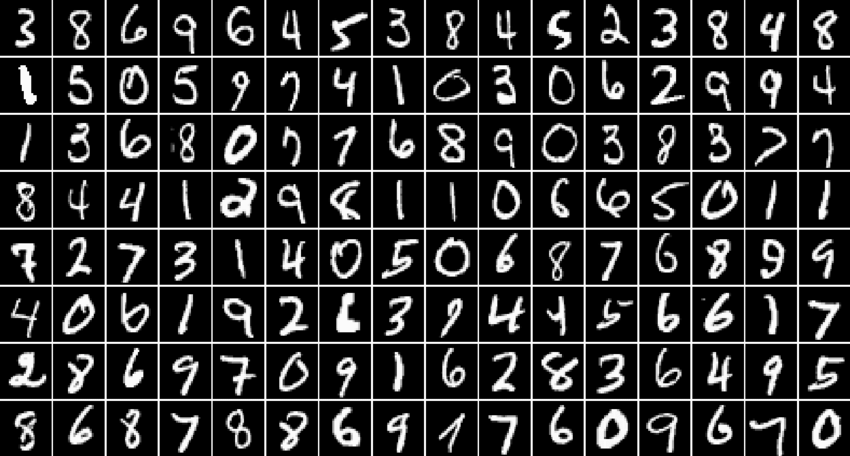

we can see that in these samples, the pixel on top left corner of the image is always completely black, if this is the case for all the images on mnist dataset, then that pixel (which is a feature) is a constant parameter and we want to ignore it. if there are some few cases where that top left corner pixel have a different value, then that feature is a constant parameter with some noise.

almost all of the pixels in the center of the images changes alot, for some numbers like 0 they are often black, for some numbers like 3 and 1 they are often white, those center pixels(features) are the paramaters that changes a lot (they have high variance along the dataset), idealy we would like to keep them.



#### Let's look at these 2D case (extreme case):

if we wanted to project 2D data in the picture below, into 1D dimension, (projecting 2D points into a single Line in 2D space) which Line should we choose? which Line describes our data better? to find the best Line, first we have to find the dominant patterns in data. in 2D examples, this dominant pattern is a line. 

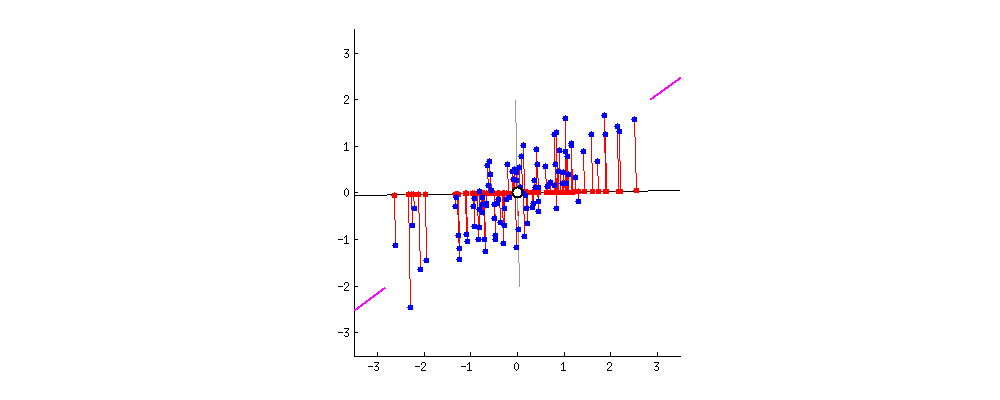

In this example, X's and Y's are higly correlated (a data point with higher X has Higher Y and vice versa), best Line that can describe our data is this line:
(it maximizes the variance of the projected data points)

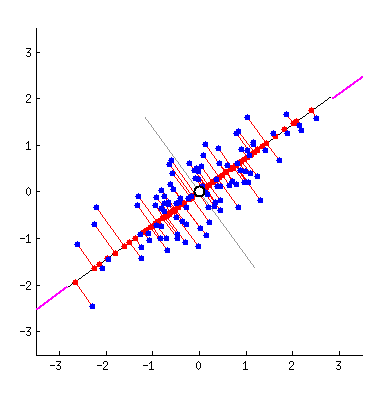

and the worst line, which minimizes the variance of projected data points is: 

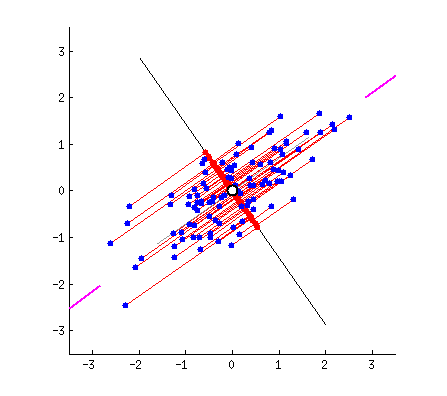

PCA aims to find linearly uncorrelated orthogonal axes, which are also known as principal components (PCs) in the m dimensional space to project the data points onto those PCs. The first PC captures the largest variance in the data.

We can use principal directions to sketch a procedure for dimensionality reduction. First, we find the principal directions of X by centering X, then using the SVD. If X has 100 dimensions, this will produce 100 principal directions. Next, we decide how many dimensions we want to reduce to. if we decided to reduce to 2 dimensions, we keep the first two principal directions and throw out the other 98. Finally, we project the data onto the first two directions. This is principal component analysis (PCA), a method for dimensionality reduction.

## Implementing PCA via SVD: 
##  Exercise 3: <a class="anchor" id="ex3"></a>
**Question1**: implement the function `pca`, which takes the data matrix $X$, performes PCA on it and returns top-k principal components and their respective eigenvalue:

this function does steps 1 - 3 of PCA via SVD that we mentioned before.

In [14]:
def pca(X, k):
    
    # Subtract mean from data
    X_mean_subtracted = X - X.mean(axis=0) # SOL 
    # perform singular value decompostion using the function implemented in exercise 3
    U, S, V = svd(X_mean_subtracted) # SOL 
    print(V, V.T, V @ V.T)
    # get top-k highest eigen values (rather singular values) in matrix S
    top_k_eig_vals = np.diagonal(S[:, 0:k]) 
    
    # get top-k principal components 
    top_k_principal_components = V.T[:, 0:k] # SOL 
    print(X.shape, top_k_principal_components.shape)
    return top_k_eig_vals, top_k_principal_components

having the top-k principle components, we can project the dataset(X) into the low dimensional subspace that principle components refer to. this is a linear transformation (linear transformation was discussed in project 1 of this semester). 
this is step 4 and 5 of the PCA via SVD which was mentioned before.

**Question2**: complete `pca_transform` function, which takes `X` performs PCA on it (using pca() function) and returns projection of `X` using the first `k` principal components:  

In [15]:
def pca_transform(X, k):
    # get top_k_eig_vals, top_k_principal_components using pca function in last exercise
    eig_vals, pc_s = pca(X, k) # SOl
    
    # First subtract the mean from dataset
    X_mean_subtracted = X-X.mean(axis=0) #SOL
    
    # project X_mean_subtracted using the matrix of top-k principal components. 
    X_transformed = (X_mean_subtracted) @ pc_s # SOL 
    return X_transformed

# Exercise 4: <a class="anchor" id="ex4"></a>
Lets look at a 2D case:

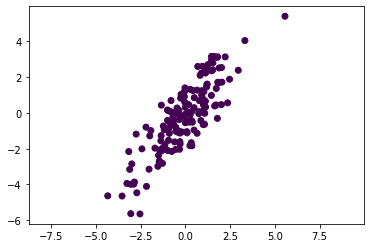

In [16]:
mean_list = [[0, 0]]
cov_mats = [[[2.5, 2.75], [2.75, 4]]]
dataset_2d = multi_var(mean_list, cov_mats, 150)
X_2d, _ = dataset_2d.get_data()
scatter_2d(X_2d)

What is the best line to project the data points into, while preserving the most information about data?
PCA gives us the answer to this question.

lets plot the principle components :

In [17]:
def plot_pcs(eig_vals, pcs, X):
    '''
    X: data matrix (n_samples, d)
    pcs: principle components of X (k, d)
    eig_vals: eigen values corresponding to the principal componants (k, )
    
    this function plots Principle Components and the original 2D data.
    '''
    overall_mean = X.mean(axis=0)
    point0 = overall_mean - np.sqrt(eig_vals[0]) * pcs[:, 0]
    point1 = overall_mean + np.sqrt(eig_vals[0]) * pcs[:, 0]
    point2 = overall_mean - np.sqrt(eig_vals[1]) * pcs[:, 1]
    point3 = overall_mean + np.sqrt(eig_vals[1]) * pcs[:, 1]

    x_prj = [point0[0], point1[0], point2[0], point3[0]]
    y_prj = [point0[1], point1[1], point2[1], point3[1]]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.tight_layout(pad=3.00)

    plt.subplot(1, 2, 1), plt.plot(x_prj[0:2], y_prj[0:2], 'k-'), plt.scatter(x = X[:, 0], y = X[:, 1], alpha=0.3), plt.axis('equal'), plt.title('First Principle Component')
    plt.subplot(1, 2, 2), plt.plot(x_prj[2:4], y_prj[2:4], 'k-'), plt.scatter(x = X[:, 0], y = X[:, 1], alpha=0.3), plt.axis('equal'), plt.title('Second Principle Component')
    
    plt.show()

**Question1**: Compute principal components of the `X_2d` data (all two of them) using the `pca` function, and pass the eigen values and principal components to the `plot_pcs` function: 

[[-0.59482871 -0.80385248]
 [-0.80385248  0.59482871]] [[-0.59482871 -0.80385248]
 [-0.80385248  0.59482871]] [[1.00000000e+00 1.86434054e-17]
 [1.86434054e-17 1.00000000e+00]]
(150, 2) (2, 2)


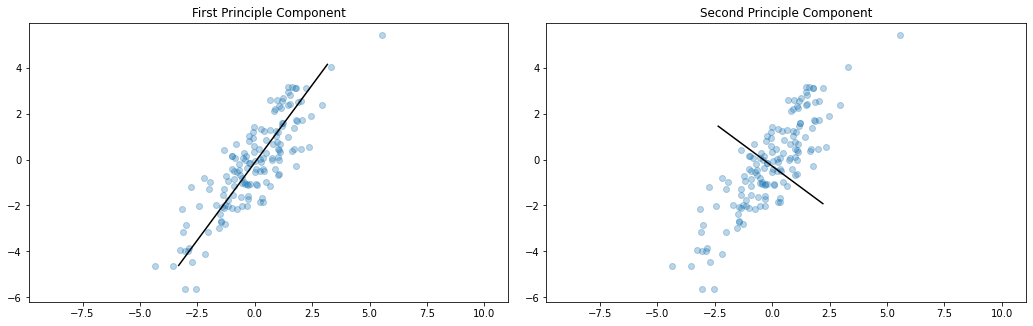

In [18]:
eig_vals, principal_components = pca(X_2d, 2) # SOL
plot_pcs(eig_vals, principal_components, X_2d)

We can see that the first principal component, which has the highest eigen value, preserves the most amount of information about data.
### Explained Variance
the next question is “how many principal components are we going to choose for our new feature subspace?” A useful measure is the so-called “explained variance,” which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [14]:
def explain_pcs(X):
    d = X.shape[1]
    eig_vals, pcs = pca(X, d)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    # for i, var_temp in enumerate(var_exp):
    #     print(f'{i}-th Principal Compnent: {var_temp}\%')
    cum_var_exp = np.cumsum(var_exp)
    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(6, 4))
        plt.bar(range(d), var_exp, alpha=0.5, align='center', label='individual explained variance')
        plt.step(range(d), cum_var_exp, where='mid', label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

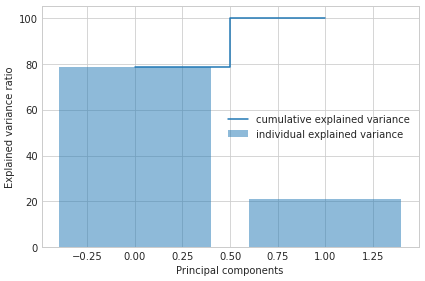

In [15]:
explain_pcs(X_2d)

As shown in the figure, first principal component shows that most of the variance (about 85% of the variance of the whole data).

lets do the same thing for two more 2D datsets:

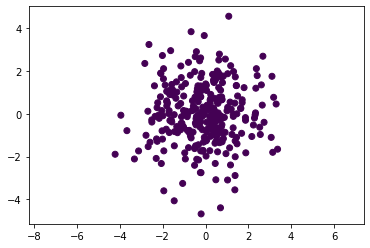

In [16]:
mean_list = [[0, 0]]
cov_mats = [[[2, 0], [0, 2]]]
dataset_2d = multi_var(mean_list, cov_mats, 300)
X_2d, _ = dataset_2d.get_data()
scatter_2d(X_2d)

**Question2**: Compute principal components of the data (all two of them) using the pca function, and pass the eigen values and principal components to the `plot_pcs` function:

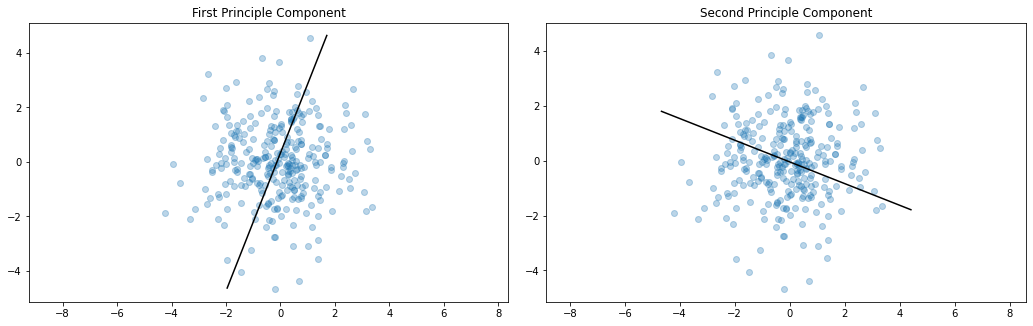

In [17]:
eig_vals, principal_components = pca(X_2d, 2) # SOL
plot_pcs(eig_vals, principal_components, X_2d)

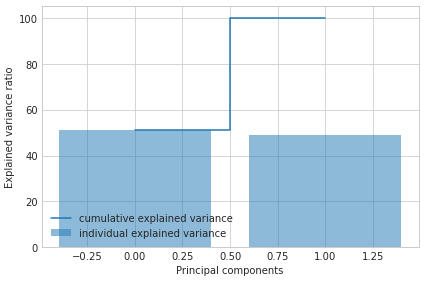

In [18]:
explain_pcs(X_2d)

In this example we can see that both of the principal compnents attribute the same amount of information to the dataset. (thus reducing dimension to either one of them results in loosing about half of the variance(information))

now lets look at an extreme example:

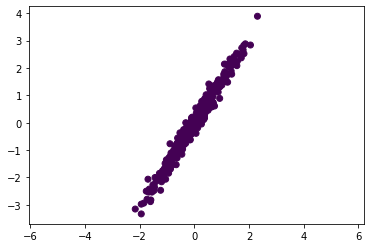

In [19]:
mean_list = [[0, 0]]
cov_mats = [[[0.8, 1.25], [1.25, 2.]]]
dataset_2d = multi_var(mean_list, cov_mats, 300)
X_2d, _ = dataset_2d.get_data()
scatter_2d(X_2d)

**Question3**: Compute principal components of the data (all two of them) using the `pca function`, and pass the eigen values and principal components to the plot_pcs function:

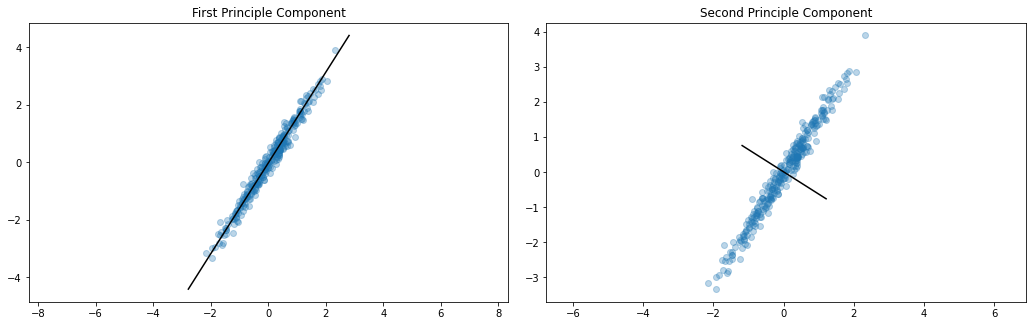

In [20]:
eig_vals, principal_components = pca(X_2d, 2) # SOL
plot_pcs(eig_vals, principal_components, X_2d)

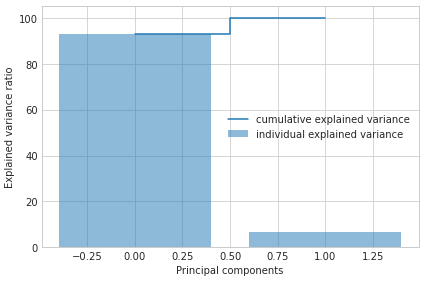

In [21]:
explain_pcs(X_2d)

In this example we can see that the first principal compnents attribute most of the information to the dataset. (thus reducing dimension to 1D preserve most of the information)


# Dimension Reduction On Mnist: <a class="anchor" id="dimension-reduction-on-mnist"></a>

In MNIST dataset, each picture is 28*28 pixels, meaning that each raw sample has 784 features. in this exercise we want to reduce dimension of mnist dataset to 2 and visualise it. 

In [22]:
X_mnist_full, y_full = get_flatten_mnist(60000)

In [23]:
def plot_mnist_2d(X, y):
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(121)
    
    for digit in np.unique(y):
        xx = X[y==digit, 0]
        
        yy = X[y==digit, 1]
        ax.scatter(xx, yy, label=int(digit),
                   alpha=1.0, edgecolors='none', marker='${}$'.format(int(digit)))

    ax.legend()
    plt.show()

In [24]:
X_mnist_full.shape

(60000, 784)

## Exercise 5 <a class="anchor" id="ex5"></a>

**Question1**: Let's transform (project) `X_mist_full` to 2D using first two Principal components: (use `pca_transform` function that we implemented before) 

$$
\text{X_mnist_full}_{60000 \times 784} \rightarrow \text{project using first 2 principal components} \rightarrow \text{X_pca}_{6000 \times 2}
$$

In [25]:
X_pca_mnist = pca_transform(X_mnist_full, 2) # SOL 

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [26]:
X_pca_mnist.shape

(60000, 2)

**Question2**: Now Use the `explain_pcs` function on `X_pca_mnist` to see how principal components describe the dataset:

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


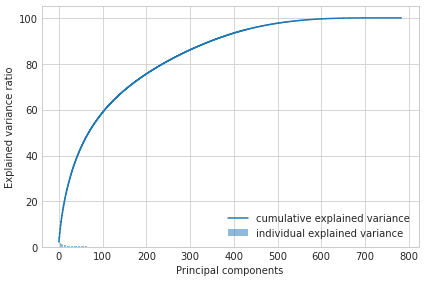

In [27]:
explain_pcs(X_mnist_full) # SOL 

**Question3**: how many principle component do we need in order to fully describe data (almost 100% explained variance) ? 

Your Answer: 

Now lets plot projected mnist dataset on 2D subspace of first 2 principle components:

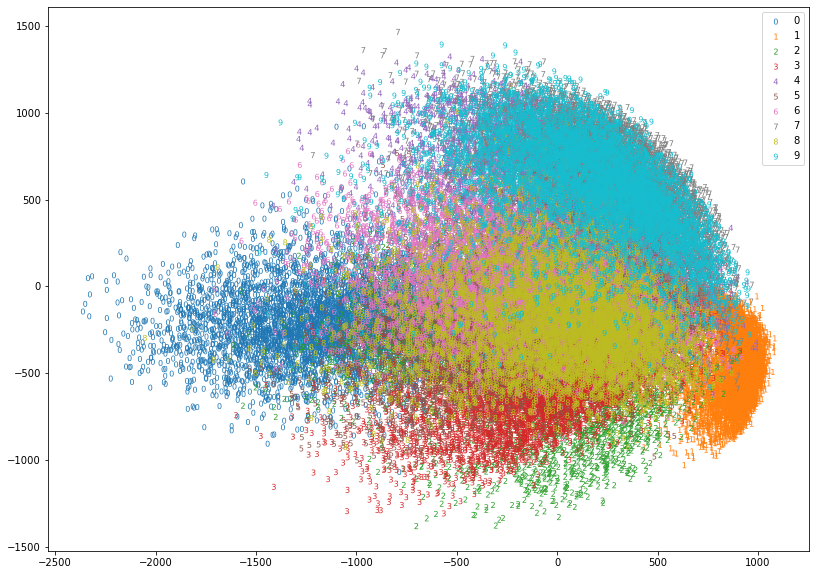

In [28]:
n_samples_to_plot = 60000
plot_mnist_2d(X_pca_mnist[0:n_samples_to_plot], y_full[0:n_samples_to_plot])

**Question4**:
Looking at the above scatter plot, What are the Most Dissimilar MNIST Digits(classes)? 

(If the scatter plot is too crowded and you can't see different labels in the plot, lower the value of `n_samples_to_plot` and run the above cell again)

Your answer: 

**NOTE**: There is no unique answer since we are relying on the visualization to guess the two most dissimilar guess classes, but if you lower the `n_samples_to_plot` to around 3000, it's clear that some classes are way too apart from each other and some classes are in the same area

Store the 2 class labels that are most dissimilar in the `class_1` and `class_2` variable:

In [29]:
class_1 = 0 # SOL 
class_2 = 1 # SOL 

`get_mnist_data_by_class` function takes the list of classes (`class_list`) and `n_samples` and looks for the first `n_sample` of samples that are in the `class_list` and returns them:

for examples `get_mnist_data_by_class([0, 1, 4], 40000)` returns samples with label 0 or 1 or 4, in the first 40000 of samples

In [30]:
def get_mnist_data_by_class(class_list, n_samples):
    '''
    returns frist "n_samples" samples of the mnist dataset that belong to "class_list"
    '''
    X, y = get_mnist_data(n_samples)
   
    X = np.reshape(X, (X.shape[0], 28*28))
    
    X_specific = X[y==class_list[0]]
    y_specific = y[y==class_list[0]][:, None]
    for i, cl in enumerate(class_list):
        if i == 0: continue
        X_specific = np.vstack((X_specific, X[y==cl]))
        y_specific = np.vstack((y_specific, y[y==cl][:, None]))

    return np.array(X_specific), np.squeeze(np.array(y_specific))
    

**Question 4**: use `get_mnist_data_by_class` function and get all the samples of two most dissimilar classes (`class_1` and `class_2`):

In [31]:
class_list = [class_1, class_2] # SOL 
n_samples = 60000 # SOL 
X_diss, y_diss = get_mnist_data_by_class(class_list, n_samples) # SOL 
X_diss.shape, y_diss.shape

((12665, 784), (12665,))

**Question5**: Transform(Project) `X_diss` to 2-dimensions using PCA and store the projection in `X_diss_pca`:

In [32]:
X_diss_pca = pca_transform(X_diss, 2) # Sol
X_diss_pca.shape

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(12665, 2)

**Question6:** Explain Variance for `X_diss` using `explain_pca` function:

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


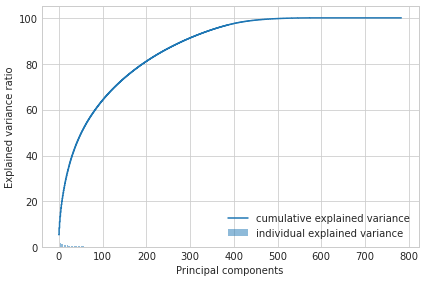

In [33]:
explain_pcs(X_diss)  # SOl 

**Question7**: how many principle component do we need to fully describe data (almost 100% explained variance) ? 

Your Answer:

**Question8:** use `plot_mnist_2d` to plot the projection of `X_diss` into 2D space:

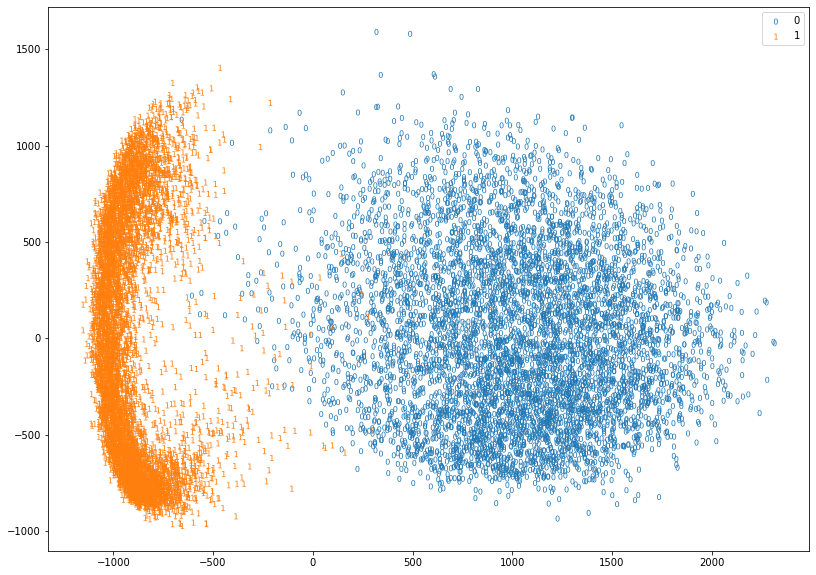

In [34]:
plot_mnist_2d(X_diss_pca, y_diss) # SOl 

As you can see, even though we are only using 2 of the first principal components, the two classes in 2D dimensions are still separable and a good amount of information maintains in 2D (enough information to seperate between digit 0 and 1). this shows the power of PCA in dimension reduction. 

## Exercise 6: <a class="anchor" id="ex6"></a> 

Looking back at the the mnist plot of full data:

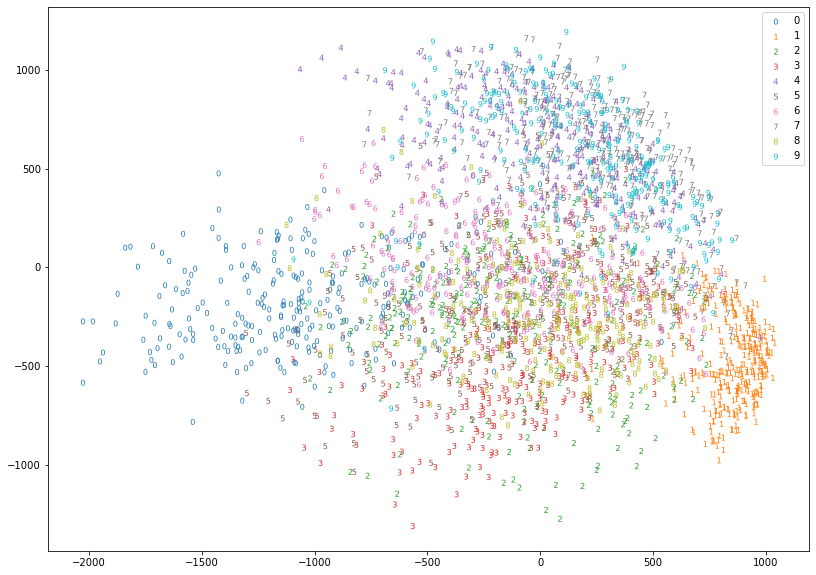

In [35]:
n_samples_to_plot = 3000
plot_mnist_2d(X_pca_mnist[0:n_samples_to_plot], y_full[0:n_samples_to_plot])

**Question1**: By looking at the above scatter plot, What are 2 classes with that are most similar? (there might not be a unique answer)

Your answer:

Store the 2 class labels that are most similar in the `class_1` and `class_2` variable:

In [36]:
class_1 = 6 # SOl 
class_2 = 8 # SOl 

**Question 2**: use `get_mnist_data_by_class` function and get all the samples of two most similar classes (`class_1` and `class_2`):

In [37]:
X_sim, y_sim = get_mnist_data_by_class([class_1, class_2], 60000) # SOl 
X_sim.shape, y_sim.shape

((11769, 784), (11769,))

**Question 3**: Transform(Project) `X_sim` to 2-dimensions using PCA and store the projection in `X_sim_pca`:

In [38]:
X_sim_pca = pca_transform(X_sim, 2) # SOl 
X_sim_pca.shape

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


(11769, 2)

**Question4:** Explain Variance for `X_sim` using `explain_pca` function:

F:\apps\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


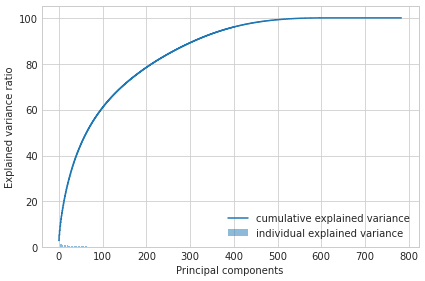

In [39]:
explain_pcs(X_sim) # SOl  

**Question7**: how many principle component do we need to fully describe data (almost 100% explained variance) ? 

Your Answer:

**Question8:** use `plot_mnist_2d` to plot the projection of `X_diss` into 2D space:

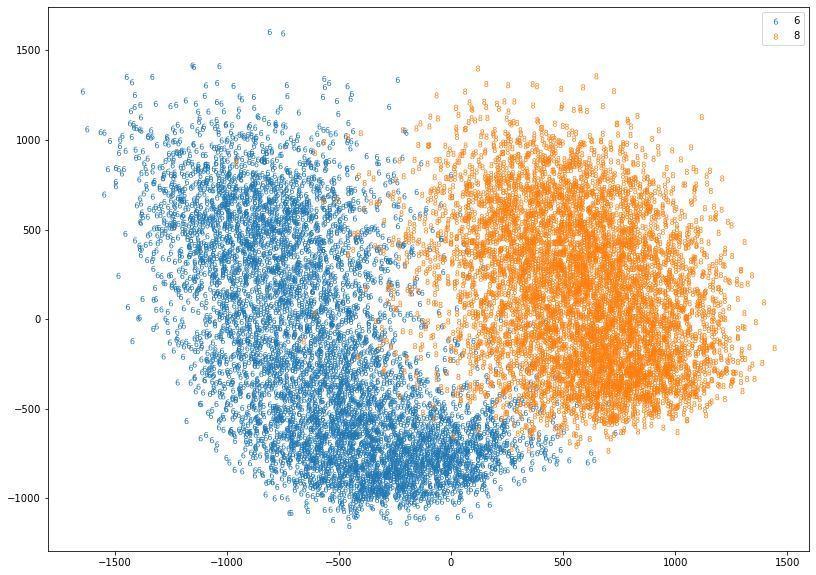

In [40]:
plot_mnist_2d(X_sim_pca, y_sim) # SOl 

Optional: 
Feel free to try reduce diffrenet classes to different dimensions. 
(you can scatter 3d plots using matplotlib, more info: https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html)

## Resources:
- https://intoli.com/blog/pca-and-svd/

- https://www.engati.com/glossary/mnist-dataset#:~:text=REQUEST%20A%20DEMO-,What%20is%20MNIST%20dataset%3F,training%20various%20image%20processing%20systems

- https://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

- http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_PCA09.pdf

- Data Driven Science & Engineering, Machine Learning, Dynamical Systems, and Control, by Steven L. Brunton and J. Nathan Kutz
